In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from dateutil import parser

preFix = '../1_rawData/cb-devices-main('
postFix = ').csv'
files = []
dfList = []

for i in range(1, 11):
    filename = preFix + str(i) + postFix
    df = pd.read_csv(filename)
    dfList.append(df)

df = pd.concat(dfList, axis=0, ignore_index=True)

setContacts = set(df[['contact_id (S)']].to_numpy().transpose().tolist()[0])
print(setContacts)

#convert timestamp strings to datetime objects
df['server_time (S)'] = df['server_time (S)'].apply(parser.parse)
df['message_sent_at (S)'] = df['message_sent_at (S)'].apply(parser.parse)

#time difference between when the message was sent and when the contact was detected
df['msg_delay'] = (df['message_sent_at (S)'] - df['server_time (S)']).dt.seconds

#time difference between when the current message at stamp and the contact reported at stamp 
df['msg_delay_stamps'] =  df['current_msg_atstamp (N)'] - df['contact_reported_atstamp (N)']


df = df[['contact_type (S)', 'contact_class_score_diff (N)',
       'contact_id (S)',
       'counter (S)', 'delay (N)', 'msg_delay', 'msg_delay_stamps']]

#display(df[['delay (N)', 'msg_delay', 'msg_delay_stamps']])


### Fork in the road, comment or uncomment the code as necessary
'''
df = df[df['delay (N)'] > 141]
'''


#display(df)
dfByIDpairsList = []
for device_id in setContacts:
    tdf = df[df['contact_id (S)'] == device_id]
    dfByIDpairsList.append(tdf)

## Potential way of cross-validating, train the model on each pair  
##  and the test data is the data from the other device pairs
##  the list below will be the lengths of the test sets
## potential balancing can be done by training on two pairs and testing on the other two
## Thus a total of 6 train and test combinations - this can be for overall permformance metric calc.
## We can also possibly do 3C2 pairs of pairings of training, and the last pairing as the test for an
## ensemble of the first three pairings. 

lenOfDevicePairs = [len(tdf) for tdf in dfByIDpairsList]
print(lenOfDevicePairs)

## Scratch all of the above ideas, since a large part of the minority class occurs with a subsection
## of the data, the pair of main_device:01BA has 97/120 instances of the class 1 contacts.

type1sInPair = [len(tdf[tdf['contact_type (S)']==1]) for tdf in dfByIDpairsList]
print(type1sInPair)


## What is a different approach to utilizing device ids ???????


##potential outliers are in one of the two subsets of the data.
potOutliers = [4, 68, 95]
numOutliers = [len(tdf[tdf['contact_class_score_diff (N)'].isin(potOutliers)]) for tdf in dfByIDpairsList]
print(numOutliers)

display(df)

{'01BA', '9328', '481F', '012D'}
[323, 224, 281, 150]
[97, 0, 18, 5]
[4, 0, 6, 0]


,contact_type (S),contact_class_score_diff (N),contact_id (S),counter (S),delay (N),msg_delay,msg_delay_stamps
0,2,91,9328,78,38,691,653
1,2,26,01BA,78,38,682,644
2,2,147,481F,68,0,636,636
3,2,26,481F,68,0,626,626
4,2,26,01BA,68,0,617,617
...,...,...,...,...,...,...,...
973,2,51,481F,14,151,153,2
974,2,147,012D,13,146,148,2
975,2,26,01BA,36,59,656,597
976,2,147,481F,51,117,714,597


In [15]:
#print(df.columns)
df1 = df[['contact_class_score_diff (N)', 'contact_type (S)']]
#display(df1.head())
import matplotlib.pyplot as plt
#plt.scatter(x=df1['contact_class_score_diff (N)'], y=df1['contact_type (S)'])
#plt.show()

import plotly.express as px
df["contact_type (S)"] = df["contact_type (S)"].astype(str) #convert to string
fig = px.scatter(df, x='contact_class_score_diff (N)', y='contact_id (S)', color='contact_type (S)')
df["contact_type (S)"] = df["contact_type (S)"].astype(int) #convert back to numeric
#title='Contact Class Score Diff vs Contact Type'
fig.show()

<AxesSubplot:>

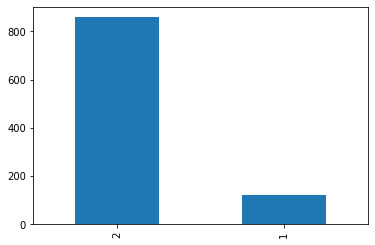

In [26]:
fig, ax = plt.subplots()
df1['contact_type (S)'].value_counts().plot(ax=ax, kind='bar')

In [23]:
setTwos = set()
setOnes = set()
valFreq = {}
for index, row in df1.iterrows():
    score, cType = row.iloc[0], row.iloc[1]
    if cType == 1:
        if score not in setOnes:
            setOnes.add(score)
        if score not in valFreq:
            valFreq[score] = 0
        valFreq[score] += 1
    else:
        if score not in setTwos:
            setTwos.add(score)
        if score not in valFreq:
            valFreq[score] = 0
        valFreq[score] += 1

print('Set of Diff values for Type 1 contacts', setOnes)
print('Set of Diff values for Type 2 contacts', setTwos)
print('Set intersection:', 'Empty Set' if len(setOnes & setTwos) == 0 else  setOnes & setTwos) 
#print('Number of times each difference value is observed', valFreq)

numOnes = 0
for val in list(setOnes):
    numOnes += valFreq[val]
numTwos = 0
for val in list(setTwos):
    numTwos += valFreq[val]

print("Class distribution 1:", numOnes, "2:", numTwos)

print('\n\nNumber of times each difference value is observed', valFreq)
## "eye-test" possible outliers - 68, 4 and 95. But large class imbalance makes it difficult to exclude 95 @ frequency = 8 (~7% of the labels)

Set of Diff values for Type 1 contacts {68, 22, 95}
Set of Diff values for Type 2 contacts {4, 122, 78, 51, 147, 53, 118, 26, 91, 93}
Set intersection: Empty Set
Class distribution 1: 120 2: 858


Number of times each difference value is observed {91: 52, 26: 113, 147: 451, 51: 130, 118: 97, 22: 111, 78: 1, 53: 7, 95: 8, 93: 4, 122: 2, 68: 1, 4: 1}


def findErrorPercent(y, y_line):
    avgErrorPercent = 0
    totalErrorPercents = 0

    for true, predicted in zip(y, y_line):
        error = abs(predicted-true)
        errorPercent = (error/true)*100
        totalErrorPercents += errorPercent

    avgErrorPercent = totalErrorPercents/len(y)
    return avgErrorPercent

def objective_poly3(x, a, b, c, d):
	return a * x + b * x**2 + c * x**3 + d

def objective_poly2(x, a, b, c):
	return a * x + b * x**2 + c

def objective_linear(x, a, b):
	return a * x + b

def objective_poly6(x, a, b, c, d, e, f, g):
    return a * x + b * x**2 + c * x**3 + d * x**4 + e * x** 5 + f * x**6 + g

errorList = []
listFunctions = [objective_linear, objective_poly2, objective_poly3, objective_poly6]
x=df1[['contact_class_score_diff (N)']].to_numpy().transpose().tolist()[0]
y=df1[['contact_type (S)']].to_numpy().transpose().tolist()[0]
for objective in listFunctions:
        popt, _ = curve_fit(objective, x, y)
        x_line = np.array(sorted(x))
        plt.scatter(x, y)

        if objective_linear == objective:
            a,b = popt
            print('y = %.5f * x + %.5f' % (a, b))
            y_line = objective(x_line, a, b)
            linear_error = findErrorPercent(y, y_line)
            errorList.append(linear_error)
        elif objective_poly2 == objective:
            a,b,c = popt
            print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
            y_line = objective(x_line, a, b, c)
            quad_error = findErrorPercent(y, y_line)
            errorList.append(quad_error)
        elif objective_poly6 == objective:
            a, b, c, d, e, f, g = popt
            y_line = objective(x_line, a, b, c, d, e, f, g)
            poly6error = findErrorPercent(y, y_line)
            errorList.append(poly6error)
        else:
            a, b, c, d = popt
            print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f' % (a, b, c, d))
            y_line = objective(x_line, a, b, c, d)
            cubic_error = findErrorPercent(y, y_line)
            errorList.append(cubic_error)
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()

print(errorList)